![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Introduction to Machine Learning </center>
## <center> Lecture 22 - RNN</center>
### <center> Vanilla RNN</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/IntroductionToMachineLearning/22_RNN/MainRNN1.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [47]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

import torch

For Colab users:

In [46]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/IntroductionToMachineLearning/22_RNN/RnnExampleAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [44]:
#-- Record figures during training:
from RnnExampleAux import Plot, Recorder, TrainLoop, ValidationLoop, TrainModel, LearningRateSweep, OneCycleScheduler

### Test 1:
* Random data with random length.
* The goal is to estimate the sequence's length.

In [5]:
#-- Min and max lengths:
minL   = 2
maxL   = 100

Ntrain = 50000
Ntest  = 10000
N      = Ntrain + Ntest

lX = []
#-- Generate random lengths:
vY  = torch.randint(minL, maxL, (N,))
for ii in range(N):
    #-- Generate a random sequence of length vY[ii]:
    vXi = torch.randn(vY[ii], 1)
    lX.append(vXi)

In [6]:
#-- A simple sequence dataset:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, lX, vY):
        self.lX = lX
        self.vY = vY
        
    def __len__(self):
        return len(self.lX)
    
    def __getitem__(self, idx):
        vXi = self.lX[idx]
        yi  = self.vY[idx]
        return vXi, yi

In [7]:
lTrainX = lX[:Ntrain]
vTrainY = vY[:Ntrain]
lTestX  = lX[Ntrain:]
vTestY  = vY[Ntrain:]

oTrainSet = SequenceDataset(lTrainX, vTrainY.float())
oTestSet  = SequenceDataset(lTestX,  vTestY.float())

### Model:

In [8]:
import torchsummary
import torch.nn as nn

class RnnModel(nn.Module):
    def __init__(self):
        super(RnnModel, self).__init__() #-- always do this
        
        self.Rnn    = nn.RNN(input_size=1, hidden_size=10, num_layers=3)
        self.Linear = nn.Linear(10, 1)

    def forward(self, mX):
        #-- Apply RNN to the batch mX:
        _, mH = self.Rnn(mX)
        #-- Get last hidden state:
        mH    = mH[-1,:,:]
        #-- Apply linear layer:
        vY    = self.Linear(mH)
        return vY

def GetModel():
    return RnnModel()

### Data loaders, device, and loss function:

In [9]:
def SequenceCollateFunction(lBatch):
    '''List of sequences to a packed PyTorch tensor'''
    lData  = []
    vY     = torch.zeros(len(lBatch), dtype=torch.float32)
    for ii, (vXi, yi) in enumerate(lBatch):
        lData.append(vXi)
        vY[ii] = yi
    
    packData = torch.nn.utils.rnn.pack_sequence(lData, enforce_sorted=False)
    return (packData, vY)


batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=SequenceCollateFunction)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=SequenceCollateFunction)

In [10]:
next(iter(oTrainDL))[0][0]

tensor([[ 0.9229],
        [ 0.5702],
        [-1.1850],
        ...,
        [ 0.6158],
        [ 0.2861],
        [-0.1750]])

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [12]:
import torch.optim as optim
LossFunc = nn.MSELoss()
# LossFunc = nn.L1Loss()

### Search learning rates:

<IPython.core.display.Javascript object>


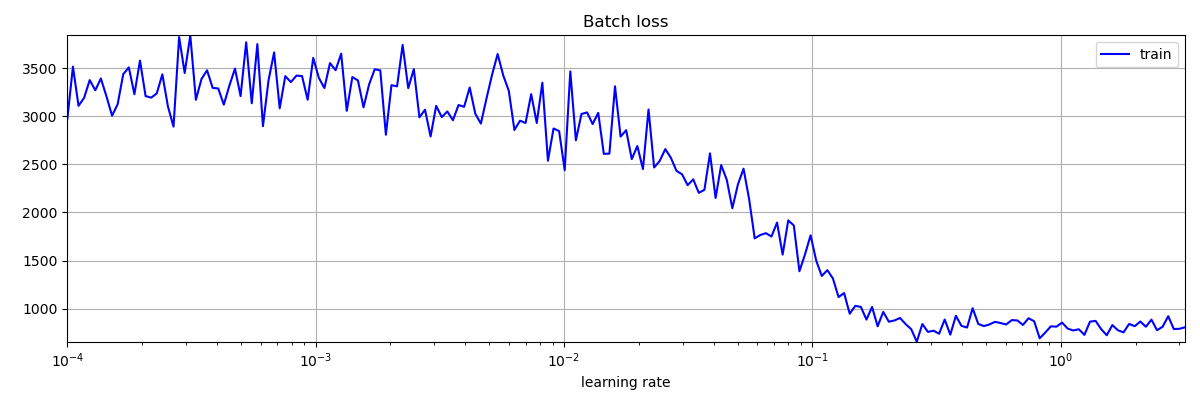

C:\Users\Or\anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [13]:
%matplotlib notebook
#-- Colab users should use `inline`
# %matplotlib inline

oModel        = GetModel().to(device)
oOptim        = optim.AdamW(oModel.parameters(), lr=0.1, betas=(0.9, 0.99), weight_decay=1e-4)
vLearningRate = np.logspace(-4, .5, 201)
oRecorder     = LearningRateSweep(oModel, oTrainDL, LossFunc, oOptim, vLearningRate)

For Colab users:

<IPython.core.display.Javascript object>


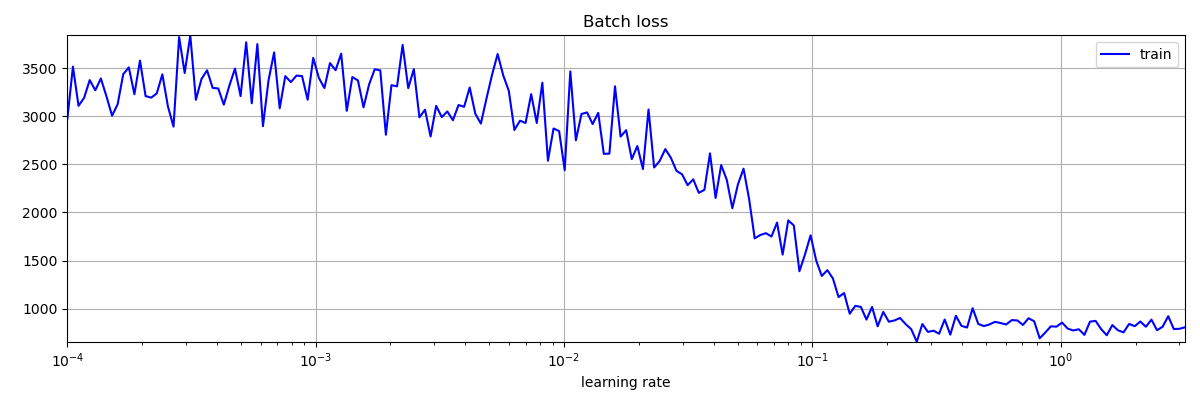

In [14]:
#%matplotlib inline
oRecorder.fig

### Train the model:

<IPython.core.display.Javascript object>


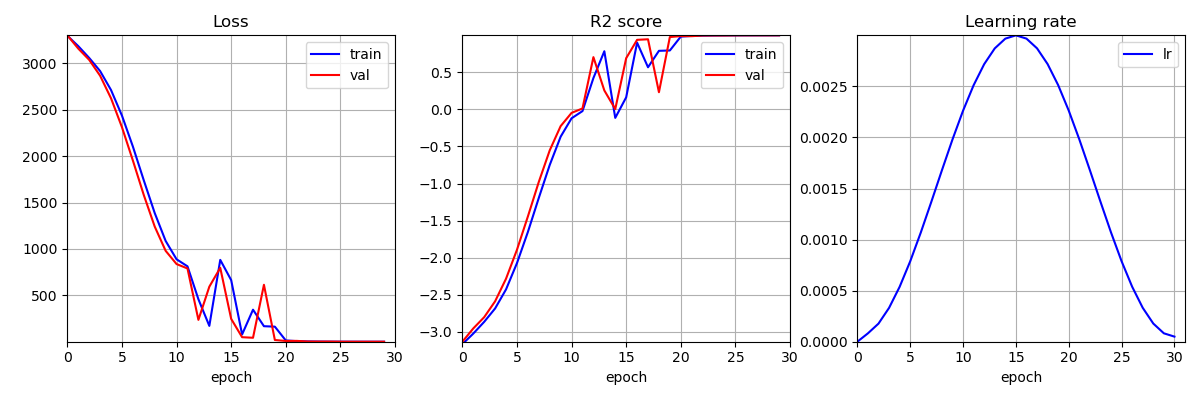

Epoch   0: | Train loss: 3296.57136 | Val loss: 3300.73604 | Train R2 score: -3.1666 | Val R2 score: -3.1332 | epoch time: 8.959 | <-- Checkpoint!
Epoch   1: | Train loss: 3184.63957 | Val loss: 3157.90370 | Train R2 score: -3.0235 | Val R2 score: -2.9543 | epoch time: 8.272 | <-- Checkpoint!
Epoch   2: | Train loss: 3057.25497 | Val loss: 3036.51434 | Train R2 score: -2.8650 | Val R2 score: -2.8022 | epoch time: 8.396 | <-- Checkpoint!
Epoch   3: | Train loss: 2915.98840 | Val loss: 2865.56069 | Train R2 score: -2.6846 | Val R2 score: -2.5880 | epoch time: 8.006 | <-- Checkpoint!
Epoch   4: | Train loss: 2711.41313 | Val loss: 2622.30154 | Train R2 score: -2.4275 | Val R2 score: -2.2832 | epoch time: 8.059 | <-- Checkpoint!
Epoch   5: | Train loss: 2436.24183 | Val loss: 2311.24400 | Train R2 score: -2.0734 | Val R2 score: -1.8935 | epoch time: 8.096 | <-- Checkpoint!
Epoch   6: | Train loss: 2103.02006 | Val loss: 1952.56252 | Train R2 score: -1.6531 | Val R2 score: -1.4441 | epoch t

In [15]:
%matplotlib notebook

oModel = GetModel().to(device)
oOptim = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=2e-2)

iterPerEpoch  = len(oTrainDL)
numEpochs     = 30
numIter       = numEpochs * iterPerEpoch
minLR         = 5e-5
maxLR         = 3e-3
vLearningRate = minLR + .5 * (maxLR - minLR) * (1 + np.cos(np.arange(numIter) / numIter * 2*np.pi + np.pi))

oScheduler = OneCycleScheduler(oOptim, vLearningRate)
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, numEpochs, oOptim, oScheduler)

### Test the model:

In [16]:
L      = torch.randint(minL, maxL, (1,))
vX     = torch.randn(1, L)
y      = oModel(vX.view(-1,1,1).to(device))
print(f'Sequence length           = {L.item()}')
print(f'Estimated sequence length = {y.item()}')
# vX.shape, y.item(), L.item()

Sequence length           = 79
Estimated sequence length = 79.60636138916016


### Test 2:
* The goal is to estimate the following function:
![f_x](https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/IntroductionToMachineLearning/22_RNN/f_x.png?raw=true)

In [30]:
minL   = 2
maxL   = 50
Ntrain = 50000
Ntest  = 10000
N      = Ntrain + Ntest

mX              = torch.rand(N, maxL)
vL              = torch.randint(minL, maxL, (N,))
mX[range(N),vL] = -1
vY              = torch.zeros(N)
for ii in range(N):
    vY[ii] = torch.sum(mX[ii,:vL[ii]]**2) - torch.sum(mX[ii,vL[ii]:]**3)

In [31]:
from torch.utils.data import TensorDataset

mTrainX = mX[:Ntrain]
vTrainY = vY[:Ntrain]
mTestX  = mX[Ntrain:]
vTestY  = vY[Ntrain:]

oTrainSet = TensorDataset(mTrainX, vTrainY.float())
oTestSet  = TensorDataset(mTestX,  vTestY.float())

### Model:

In [32]:
import torchsummary
import torch.nn            as nn
import torch.nn.functional as F

class RnnModel(nn.Module):
    def __init__(self):
        super(RnnModel, self).__init__() #-- always do this
        
        self.Rnn    = nn.RNN(input_size=1, hidden_size=10, num_layers=3)
        self.Linear = nn.Linear(10, 1)

    def forward(self, mX):
        #-- Input to PyTorch RNN is: (seq_len, batch, input_size):
        mX      = mX.transpose(0, 1).unsqueeze(2)
        #-- Apply RNN to the batch mX:
        _, mH   = self.Rnn(mX)
        #-- Apply Linear layer to the last hidden state:
        vY       = self.Linear(mH[-1])
        return vY

def GetModel():
    return RnnModel()

In [33]:
batchSize = 100
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize)

<IPython.core.display.Javascript object>


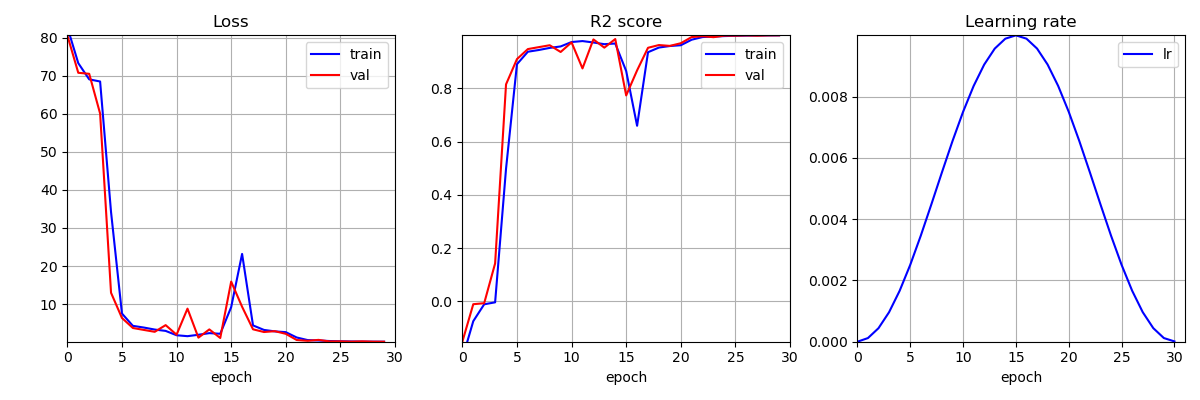

Epoch   0: | Train loss:   82.78204 | Val loss:   80.61914 | Train R2 score: -0.2143 | Val R2 score: -0.1510 | epoch time: 5.206 | <-- Checkpoint!
Epoch   1: | Train loss:   73.30942 | Val loss:   70.77811 | Train R2 score: -0.0740 | Val R2 score: -0.0103 | epoch time: 5.269 | <-- Checkpoint!
Epoch   2: | Train loss:   69.05274 | Val loss:   70.51351 | Train R2 score: -0.0106 | Val R2 score: -0.0066 | epoch time: 5.179 | <-- Checkpoint!
Epoch   3: | Train loss:   68.48913 | Val loss:   60.06307 | Train R2 score: -0.0033 | Val R2 score: +0.1427 | epoch time: 5.010 | <-- Checkpoint!
Epoch   4: | Train loss:   34.20990 | Val loss:   12.98110 | Train R2 score: +0.4978 | Val R2 score: +0.8144 | epoch time: 5.005 | <-- Checkpoint!
Epoch   5: | Train loss:    7.52403 | Val loss:    6.35502 | Train R2 score: +0.8900 | Val R2 score: +0.9091 | epoch time: 4.974 | <-- Checkpoint!
Epoch   6: | Train loss:    4.28811 | Val loss:    3.72376 | Train R2 score: +0.9368 | Val R2 score: +0.9468 | epoch t

In [34]:
%matplotlib notebook

oModel = GetModel().to(device)
oOptim = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=2e-2)

iterPerEpoch  = len(oTrainDL)
numEpochs     = 30
numIter       = numEpochs * iterPerEpoch
minLR         = 1e-5
maxLR         = 1e-2
vLearningRate = minLR + .5 * (maxLR - minLR) * (1 + np.cos(np.arange(numIter) / numIter * 2*np.pi + np.pi))

oScheduler = OneCycleScheduler(oOptim, vLearningRate)
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, numEpochs, oOptim, oScheduler)